In [15]:
import numpy as np
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data

#### Load deep ensemble

In [16]:
# Number of models in ensemble
M = 5
# Number of hidden layers
L = 2

network = 'mnist'
suffix = 'mnist-'

w = []
b = []

# Iterate over models
for m in range(M):
    W = np.load(f'networks/{network}-{m}.npz')

    # Put weights into list of arrays
    w.append([None] * (L + 1))
    b.append([None] * (L + 1))
    for ll in range(L + 1):
        w[m][ll] = W['w' + str(ll + 1)]
        b[m][ll] = W['b' + str(ll + 1)]

In [17]:
# Define model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fcs = [nn.Linear(784, 20),nn.Linear(20, 20),nn.Linear(20, 10)]

    def forward(self, x):
        x = x.view(-1,28*28)
        x = F.relu(self.fcs[0](x))
        x = F.relu(self.fcs[1](x))
        x = F.softmax(self.fcs[2](x),dim=1) 
        return x

In [18]:
# Define model
class Ensemble(nn.Module):
    def __init__(self):
        super(Ensemble, self).__init__()
        self.estimators = [MLP() for i in range(M)]##

    def forward(self, x):#
        outputs = [estimator(x) for estimator in self.estimators]
        return sum(outputs) / M

# Initialize model
model = Ensemble()

In [19]:
from torchvision import datasets, transforms

transform=transforms.Compose([
    transforms.ToTensor()
    ])
dataset1 = datasets.MNIST('../data', train=True, download=True,
                   transform=transform)
dataset2 = datasets.MNIST('../data', train=False,
                   transform=transform)




In [20]:
with torch.no_grad():
    for i, estimator in enumerate(model.estimators):
        for j, fc in enumerate(estimator.fcs):
            weights = torch.tensor(np.transpose(w[i][j]))
            bias = torch.tensor(b[i][j])
            fc.weight = nn.Parameter(weights)
            fc.bias = nn.Parameter(bias)

In [21]:
# Load the dataset
(X, y), (Xt, yt) = mnist.load_data()

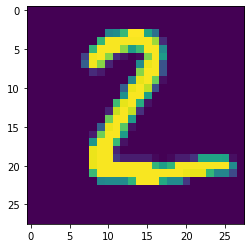

tensor([[2.3481e-05, 4.0521e-02, 9.5424e-01, 2.0878e-03, 2.6665e-05, 1.1058e-03,
         1.2291e-03, 3.8758e-07, 7.6789e-04, 2.6362e-06]],
       grad_fn=<DivBackward0>)


In [22]:
# Test ensemble output

i = 1
plt.imshow(Xt[i])
plt.show()

x = torch.tensor(Xt[i]/255).float()
y = torch.tensor(yt)
print(model(x))

In [23]:
def pgd_attack(model, images, labels, eps=0.3, alpha=2/255, steps=40, device="cpu", score="normal"):
    images = images.clone().detach().to(device)
    labels = labels.clone().detach().to(device)
    
    adv_images = images.clone().detach()
    # Starting at a uniformly random point
    adv_images = adv_images + torch.empty_like(adv_images).uniform_(-eps, eps)
    adv_images = torch.clamp(adv_images, min=0, max=1).detach()

    for _ in range(steps):
        adv_images.requires_grad = True
        outputs = model(adv_images)

        # Calculate loss
        if score == "normal":
            loss = nn.CrossEntropyLoss()
            cost = loss(outputs, labels)
        elif score == "nll":
            cost = -outputs[0][labels[0]]
        elif score == "brier":
            cost = -(1 -outputs[0][labels[0]])**2
            for i, output in enumerate(outputs[0]):
                cost -= output * output

        # Update adversarial images
        grad = torch.autograd.grad(cost, adv_images,
                                   retain_graph=False, create_graph=False)[0]

        adv_images = adv_images.detach() + alpha*grad.sign()
        delta = torch.clamp(adv_images - images, min=-eps, max=eps)
        adv_images = torch.clamp(images + delta, min=0, max=1).detach()
    return adv_images, cost

In [24]:
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=1, shuffle=False)

## NLL

In [26]:
def nll(output, label):
    return -np.log(output[label])

for eps in [0.008, 0.012, 0.016,0.02,0.024]:
    _sum = []
    _sum_attack = []
    model.eval()
    it = 0
    for images, labels in test_loader:
        #print(labels)
        outputs = model(images)
        #print(outputs)
        score = nll(outputs.detach().numpy()[0], labels[0])
        #print(score)
        _sum.append(score)
        min_attacked = -10000
        for _ in range(10):
            imagesPrime, cost = pgd_attack(model, images,labels,eps=eps, score="nll")
            outputs = model(imagesPrime)
            #print(outputs)
            score = nll(outputs.detach().numpy()[0], labels[0])
            if score > min_attacked:
                min_attacked = score
        #print(score)
        _sum_attack.append(min_attacked)
        it += 1
        if it == 100:
            break
    print(eps, np.mean(_sum), np.mean(_sum_attack))

0.008 0.1054634 0.20161545
0.012 0.1054634 0.2849737
0.016 0.1054634 0.40739113
0.02 0.1054634 0.57429814


KeyboardInterrupt: 

# Brier

In [27]:
def brier(output, label):
    score = 0
    for i, v in enumerate(output):
        if i == label:
            score += (1 - v)**2
        else:
            score += v * v
    return score


for eps in [0.008, 0.012, 0.016,0.02,0.024]:
    _sum = []
    _sum_attack = []
    model.eval()
    it = 0
    for images, labels in test_loader:
        #print(labels)
        outputs = model(images)
        #print(outputs)
        score = brier(outputs.detach().numpy()[0], labels[0])
        #print(score)
        _sum.append(score)
        min_attacked = -10000
        for _ in range(10):
            imagesPrime, cost = pgd_attack(model, images,labels,eps=eps, score="brier")
            outputs = model(imagesPrime)
            #print(outputs)
            score = brier(outputs.detach().numpy()[0], labels[0])
            if score > min_attacked:
                min_attacked = score
        #print(score)
        _sum_attack.append(min_attacked)
        it += 1
        if it == 100:
            break
    print(np.mean(_sum), np.mean(_sum_attack))

0.047849491613552744 0.060775096936517496
0.047849491613552744 0.07329527899557138
0.047849491613552744 0.10389726070855594
0.047849491613552744 0.12837073868584073
0.047849491613552744 0.1645941998446518
